[MIT License](https://github.com/cdslaborg/paramonte#license)  
[ParaMonte: plain powerful parallel Monte Carlo library](https://github.com/cdslaborg/paramonte).  
Copyright (C) 2012-present, [The Computational Data Science Lab](https://www.cdslab.org/#about)  
https://github.com/cdslaborg/paramonte  
[References](https://www.cdslab.org/paramonte/notes/overview/preface/#how-to-acknowledge-the-use-of-the-paramonte-library-in-your-work)  

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
%matplotlib notebook
import paramonte as pm
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))
sns.set()

paramonte 2.4.0
numpy 1.19.4
scipy 1.5.4
pandas 1.1.5
seaborn 0.11.0
matplotlib 3.3.3


## Modeling the bivariate distribution of a data set subject to sample incompleteness  

Supposed we have observed a dataset comprised of $1000$ events with two attributes `variable1` and `variable2` in this [data.csv](https://github.com/cdslaborg/paramontex/raw/main/Python/Jupyter/regression_censored_bivariate_lognormal_data_paradram/data.csv) file. Plotting these points would yield a red-colored bivariate distribution similar to the following figure,  
  
<br><img src="https://github.com/cdslaborg/paramontex/raw/main/Python/Jupyter/regression_censored_bivariate_lognormal_data_paradram/data.png" width="60%"/><br>
  
The pale black points represent the missing data from our observational dataset. These are points that we could NOT observe (or detect) because of some instrumental bias and sample incompleteness as represented by the black line.

**Statement of problem**  

Now, our goal is to form a hypothesis about this dataset, that is, a hypothesis about the distribution of the red points in the above plot. To make a correct assessment, we will have to also carefully consider the effects of the detection threshold (the black line) in our inference.  

The first thing we can do is to obtain a better visualization of this dataset. **A Good visualization of data is essential to form a good hypothesis (model) for our problem**. The bivariate data in the above plot looks highly skewed to the right. Therefore, it makes sense to take the logarithm of this dataset in the hope that it can help us better understand the possible underlying generating distribution of this data,  
  
<br><img src="https://github.com/cdslaborg/paramontex/raw/main/Python/Jupyter/regression_censored_bivariate_lognormal_data_paradram/logdata.png" width="60%"/><br>

Just by looking at the observed (red) data points, we can form a relatively good hypothesis about the distribution of the data: **If the detection threshold did not exist, the complete dataset (including the points in the black points) would have likely very well resembled a bivariate lognormal distribution (or a normal distribution on the logarithmic axes)**.  

However, this dataset is affected by the detection threshold and we need to take a model of the detection threshold also into account. The logarithmic transformation makes it crystal-clear to us that the detection threshold is likely best modeled as a line.  

Therefore, we form the following hypothesis,  

**Hypothesis**: Our data comes from a bivariate Lognormal distribution subject to censorship by a sharp hard cutoff threshold in the form of a line. The proposition that the data is jointly lognormally distributed is mathematically equivalent to the proposition stating that `log(data)` is normally distributed.  

**Goal**: To **estimate the unknown parameters** of the bivariate Normal distribution which is hypothesized to well fit the bivariate distribution of the *log-transformed* data. These parameters include the **mean vector** of length two and the **covariance matrix** of the full bivariate Normal distribution ($\mu, \Sigma$), as well as the intercept and the slope ($c_0,c_1$) of the **sharp linear detection threshold** on our data set ($\eta$). A two-dimensional covariance matrix has 3 free parameters because of its symmetry. Therefore, our censored model has overall 7 unknown parameters which must be constrained.  

**Methodology**: We will use the maximum likelihood approach and  the **ParaDRAM** (**Delayed-Rejection Adaptive Metropolis-Hastings Markov Chain Monte Carlo**) sampler of the `paramonte` library to estimate the 7 unknown parameters of our hypothesis.  

## Step 1: Read the data and log-transform it  

First read the data using Pandas library, then log-transform data to make it look like a bivariate Normal distribution.

In [3]:
url = "https://github.com/cdslaborg/paramontex/raw/main/Python/Jupyter/regression_censored_bivariate_lognormal_data_paradram/data.csv"
df = pd.read_csv(url) # log-transform data to be fit by a Normal distribution
X = np.double(df.iloc[:,0])
Y = np.double(df.iloc[:,1])
logX = np.log(X)
logY = np.log(Y)
df.head()

variable1  variable2
0    0.87479    1.46020
1    0.12309    0.19028
2    3.32940    6.21360
3    0.62906    1.66630
4    0.38734    0.52181

<IPython.core.display.Javascript object>


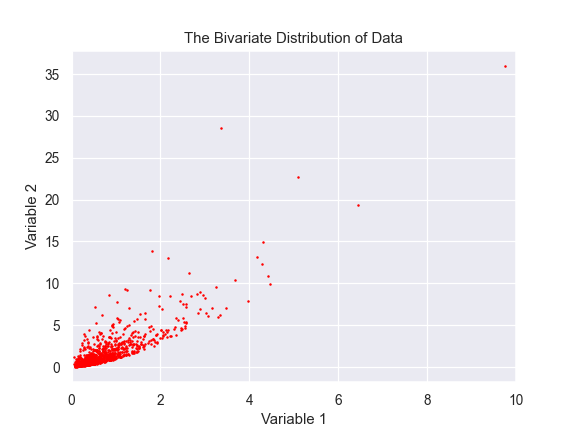

<IPython.core.display.Javascript object>


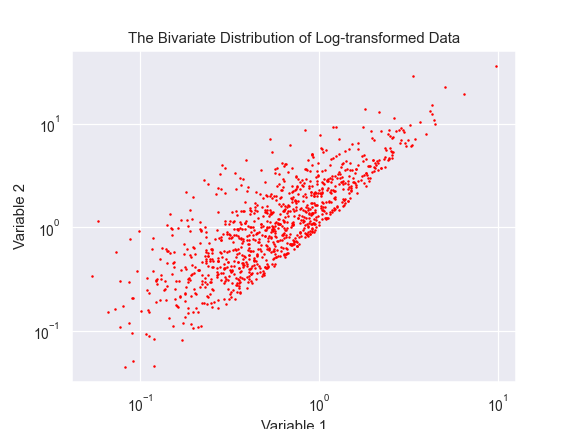

In [4]:
# plot the bivariate distribution of data

fig = plt.figure()
ax = fig.gca()
plt.scatter(X,Y,s=1,c="red")
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.title('The Bivariate Distribution of Data')
ax.set_xlim([0,10])
plt.grid(True)
plt.show()

# plot the bivariate distribution of log(data)

fig = plt.figure()
ax = fig.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.scatter(X,Y,s=1,c="red")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.title('The Bivariate Distribution of Log-transformed Data')
plt.grid(True)
plt.show()

## Step 2: Compute the probability of observing each data point under the hypothesis  

We will write a class that takes the `log(data)` as input and has three methods, most importantly `getLogLike(param)`. This method must take the set of the parameters of our censored model as a vector. **We want to explore the shape of this 7-dimensional likelihood function** to find its mode and its width along the axes, each of which represents one parameter of our model.  

Here is the mathematical equation of the MultiVariate Normal (MVN) Probability Density Function (PDF), $\large\pi(\cdot)$,  

$$
\large
\pi ( \vec{x} ~|~ \mu, \Sigma, k = 2) = (2\pi)^{-\frac{k}{2}} ~ |\Sigma|^{-\frac{1}{2}} ~ 
\exp
\bigg( 
-\frac{1}{2} (x-\mu)^T ~ \Sigma^{-1} ~ (x-\mu)
\bigg)
$$

where $k=2$ represents the number of dimensions of our data set, and in this paricular problem, 

$$
\large
\begin{eqnarray}
    \mu ~&=&~ \big[ \mu_{x}, \mu_{y} \big] ~, \\
    \Sigma ~&=&~
    \begin{bmatrix}
        \sigma_{x} ~,~ \rho\sigma_{x}\sigma_{y} \\
        \rho\sigma_{x}\sigma_{y} ~,~ \sigma_{y}
    \end{bmatrix} ~,
\end{eqnarray}
$$

where $\sigma_{x}$ and $\sigma_{y}$ represent the standard deviations of log-transformations of `variable1` and `variable2` in our dataset, and $\rho$ represents the amount of corelation between the two variables.  

However, our problem is more complicated than the above equation. The above equation gives the probability of obtaining a specific observation with a pair of attributes ($x,y$) from a *full* MVN distribution, whereas the MVN distribution in our problem is heavily censored on its right. We must therefore take this censorship into account by renormalizing the above equation such that the integral of the *censored* MVN PDF becomes unity again just as is the case for the above equation.  

For a given censorship cutoff line ($\eta$) with intercept and slope ($c_0,c_1$), the intergal of the censored MVN PDF does not have a closed-form analytical solution (except in trivial cases, such as when the detection line is vertical or horizontal). Therefore, we will have to use numerical integration methods to intergate the censored MVN PDF over the entire area above the censorship line.  

We will take the following strategy to integrate our censored 2D MVN PDF model: The integral of a univariate normal distribution is analytically known as a function of the [**error function**](https://en.wikipedia.org/wiki/Error_function). For a given value of `variable2` along the y-axis and an upper ($\eta$) limit for the value of `variable1` (which is dictated by the detection threshold), the differential probability of having an observation with a value of $x_2$ for `variable2` is the probability of observing the value $y$ marginalized over all possible values of `variable1` (subject to the detection threshold).  

$$
\large
\begin{eqnarray}
\pi (Y = y ~|~ \mu, \Sigma, c_0, c_1) 
~&=&~ \pi\big(Y = y ~|~ \mu_y, \sigma_y \big) ~ \int^{\eta}_{-\infty} \mathcal{N}\big(X=x ~|~ \mu_{x|y}, \sigma_{x|y}\big) ~ dx \\
~&=&~ \mathcal{N} \big( Y = y ~|~ \mu_y, \sigma_y \big) ~ \frac{1}{2} \bigg[ 1 + \mathrm{erf} \bigg( \frac{\eta-\mu_{x|y}}{\sigma_{x|y}\sqrt{2}} \bigg) \bigg] ~,
\end{eqnarray}
$$

where ($\mu_{x|y},\sigma_{x|y}$) represent the mean and the standard deviation of the conditional distribution of `variable2` given a particular value for `variable1`, 

$$
\large
\begin{eqnarray}
    \mu_{x|y} &=& \mu_x + \rho\frac{\sigma_x}{\sigma_y}(y - \mu_y) ~, \\
    \sigma_{x|y} &=& ( 1 - \rho^2) ~ \sigma_x^2 ~,
\end{eqnarray}
$$

Therefore, the full integral of the censored MVN PDF for a given set of parameters ($\mu,\Sigma,c_0,c_1$) can be computed as,

$$
\large
I = \int^{-\infty}_{+\infty} ~ \pi (y ~|~ \mu, \Sigma, c_0, c_1) ~ dy ~,
$$

implying that we will have to multiply all PDF values by,  

$$
\large
A = \frac{1}{I} ~,
$$ 

to properly normalize the censored MVN PDF. The above intergal will have to computed numerically and we will do so via Reomberg's method of integration. In practice, much of the integrand is concentrated close to the mean. Therefore, integrating the integrad within a few standard deviations neighborhood of the mean of the integrand should be accurate enough for the purpose of this example.  
All in all, the probability of observing each pair of ($x,y$) represented by the vector $\vec{x}$ in our data set, subject to a given detection threshold, can be computed via the following equation,  

$$
\large
\pi ( \vec{x} ~|~ \mu, \Sigma, c_0, c_1, k = 2) = 
\begin{cases}
    A~(2\pi)^{-\frac{k}{2}} ~ |\Sigma|^{-\frac{1}{2}} ~ 
    \exp \bigg( -\frac{1}{2} (x-\mu)^T ~ \Sigma^{-1} ~ (x-\mu) \bigg) ~,~ {\normalsize\text{when data is observable}} \\
    0 ~,~ {\normalsize\text{when data is non-observable (i.e., falls below the censorship line)}}
\end{cases}
$$  

## Step 3: Compute the likelihood of data for a given set of parameters  

Now, with an equation at hand to compute the probabilities of individual data points for a given set of model parameters, we can go on to write the likelihood of observing the entire dataset of $N=1000$ observations for a given set of input parameters,  

$$
\large
\begin{eqnarray}
    \mathcal{L} ( \text{data} ~;~ \mu, \Sigma, c_0, c_1, k = 2) 
    ~&\equiv&~ \pi ( \text{data} ~|~ \mu, \Sigma, c_0, c_1, k = 2) \\
    ~&=&~ \prod_{i=1}^{1000} ~ \pi \bigg( (x_i,y_i) ~\bigg|~ \mu, \Sigma, c_0, c_1, k = 2 \bigg)
\end{eqnarray}
$$

We can now implement the above likelihood function to find the most likely set of parameters for our hypothesis.  

---  

> Since the mathematical objective functions (e.g., probability density functions and likelihood functions) can take extremely small or large values, we often work with their natural logarithms instead. **This is the reason behind the naming convention used in the ParaMonte library for** the user's objective functions: **getLogFunc**, implying that **the user must provide a function that returns the natural logarithm of the target objective function**.  
  
  
See [this Jupyter Notebook](https://nbviewer.jupyter.org/github/cdslaborg/paramontex/blob/main/Python/Jupyter/working_with_logarithm_of_objective_function/working_with_logarithm_of_objective_function.ipynb) for an in-depth discussion of why we need to work with the logarithm of mathematical objective functions in optimization and sampling problems.  

---  

**Tip**  

Before implementing the likelihood function, let's ask ourselves a few questions,  

+ What is the possible range of the mean of a Normal distribution? $[-\infty, +\infty]$  

+ What are the possible ranges of the intercept and slope of the censorship line in our problem?  $[-\infty, +\infty]$, although practically, a a range of slope and intercept values for which the observed data falls below the censirship line cannot be valid, because data cannot exist below the detection threshold. 

+ What is the possible range of the standard deviation ($\sigma$) of a Normal distribution? By definition, $[0, +\infty]$  

+ What is the possible range of a correlation coefficient ($\rho$) between two attributes of a dataset? By definition, $[-1, +1]$  

Now, compare the range of the standard deviation of a Normal distribution with the ranges of the other parameters in the above.  

Did you notice the asymmetric range of the standard deviation compared to the others?  

This may not seem like a big deal, but wouldn't it be much nicer if the *theoretical* range of `std` also looked symmetric like the other parameters? This is surely possible.  

**Symmetrizing the range of the standard deviation values**  
>To make the range of a standard deviation ($\sigma$) parameter span from negative infinity to positive infinity, we can take the logarithm of $\sigma$ and instead try to find the best-fit $\log(\sigma)$ whose range is $[-\infty, +\infty]$.  

**Symmetrizing the range of the correlation coefficient values**  
>To make the range of a correlation coefficient ($\rho$) parameter also span from negative infinity to positive infinity, we can use the Fisher transform of $\rho$ to find the best-fit $z\equiv\text{Fisher-transform}(\rho)$ whose range is $[-\infty, +\infty]$.  

Here is an implementation of our censored Normal Hypothesis class,  

In [5]:
from scipy.integrate import romberg
from scipy.stats import norm

class Normal():
    
    def __init__(self, logX, logY):
        if len(logX) != len(logY): return print("Error: dataset lengths not equivalent")

        self.data = np.transpose(np.double([logX,logY]))
        self.ndata = len(logX)
        self.NVAR = 2
        self.coef0 = self.NVAR * np.log( 1. / np.sqrt(2.*np.pi) )        

        self._rho = None
        self._stdX = None
        self._stdY = None
        self._covMat = None
        self._meanVec = None
        self._stdRatio = None
        self._stdXGivenY = None
        self._cutoffIntercept = None
        self._cutoffSlopeInverse = None
        self._lowerLimY = None # for romberg intergation
        self._upperLimY = None # for romberg intergation

    def integrateXGivenY(self,yval):
        avgXGivenY = self._meanVec[0] + self._stdRatio * self._rho * (yval - self._meanVec[1])
        threshX = (yval - self._cutoffIntercept) * self._cutoffSlopeInverse 
        return norm.pdf(x = yval, loc = self._meanVec[1], scale = self._stdY) \
             * norm.cdf(x = threshX, loc = avgXGivenY, scale = self._stdXGivenY)

    def getNormFac(self, vec_func = False):
        return romberg ( function = self.integrateXGivenY
                       , a = self._lowerLimY
                       , b = self._upperLimY
                       , vec_func = vec_func
                       , tol = 1.e-4
                       , divmax = 8
                       )

    def getLogLike_slow(self, param):
        """
        Return the natural logarithm of the likelihood of 
        observing the input data given the input parameters.
        This function is a naive slow implementation of the 
        likelihood function which relies on looping over data.
        As such, it is about 100 times slower than the equivalent
        vectorized fast version of this method named getLogLike() below.
        This function exists only for the purpose of illustrating the importance of 
        avoiding loops in Python and vectorizing your calculations as much as possible.
        Order of variables in the input param vector:
        param[0] = avg(x)
        param[1] = avg(y)
        param[2] = logStd(x)
        param[3] = logStd(y)
        param[4] = FirsherTrans(self._rho)
        param[5] = cutoffSlope
        param[6] = cutoffIntercept
        """
        self._rho = np.tanh(param[4])
        self._meanVec = np.double(param[0:2])
        self._covMat = np.zeros([self.NVAR,self.NVAR])
        self._stdX = np.exp(param[2])
        self._stdY = np.exp(param[3])
        self._covMat[0,0] = (self._stdX)**2
        self._covMat[1,1] = (self._stdY)**2
        self._covMat[1,0] = self._rho * self._stdX * self._stdY
        self._covMat[0,1] = self._covMat[1,0]
        self._stdXGivenY = np.sqrt( self._covMat[0,0] * (1-self._rho**2) )
        self._stdRatio = self._stdX / self._stdY
        self._cutoffSlopeInverse = 1 / param[5]
        self._cutoffIntercept = param[6]
        significance = 3 * self._stdY
        self._lowerLimY = self._meanVec[1] - significance
        self._upperLimY = self._meanVec[1] + significance

        if np.linalg.det(self._covMat)==0:
            sys.exit("The impossible happended. Covariance matrix not positive-definite.")
        
        invCovMat = np.linalg.inv(self._covMat) # This is the inverse of the covariance matrix of the MVN distribution.

        # The following is the log of the coefficient used in the definition of the MVN.

        coef = self.coef0 + np.log( np.sqrt(np.linalg.det(invCovMat)) )  

        # the logarithm of objective function: log(MVN)

        logLike = 0.
        for obs in self.data:
            if obs[1] < (param[5] * obs[0] + param[6]): 
                # It is impossible to observe any data point that falls below the
                # censorship line. Therefore, if the input parameters result in a 
                # censorship line that is above even a single observation, then, 
                # return negative infinity to indicate impossible set of model parameters.
                return -1.e100 # -np.inf
            else:
                normedPoint = self._meanVec - obs
                logLike += coef - 0.5 * ( np.dot(normedPoint, np.matmul(invCovMat,normedPoint)) )
        return logLike - np.log(self.getNormFac())*self.ndata

    def getLogLike_fast(self, param):
        """
        Return the natural logarithm of the likelihood of 
        observing the input data given the input parameters.
        Order of variables in the input param vector:
        param[0] = avg(x)
        param[1] = avg(y)
        param[2] = logStd(x)
        param[3] = logStd(y)
        param[4] = FirsherTrans(self._rho)
        param[5] = cutoffSlope
        param[6] = cutoffIntercept
        """
        self._rho = np.tanh(param[4])
        self._meanVec = np.double(param[0:2])
        self._covMat = np.zeros([self.NVAR,self.NVAR])
        self._stdX = np.exp(param[2])
        self._stdY = np.exp(param[3])
        self._covMat[0,0] = (self._stdX)**2
        self._covMat[1,1] = (self._stdY)**2
        self._covMat[1,0] = self._rho * self._stdX * self._stdY
        self._covMat[0,1] = self._covMat[1,0]
        self._stdXGivenY = np.sqrt( self._covMat[0,0] * (1-self._rho**2) )
        self._stdRatio = self._stdX / self._stdY
        self._cutoffSlopeInverse = 1 / param[5]
        self._cutoffIntercept = param[6]
        significance = 3 * self._stdY
        self._lowerLimY = self._meanVec[1] - significance
        self._upperLimY = self._meanVec[1] + significance

        if np.linalg.det(self._covMat)==0:
            sys.exit("The impossible happended. Covariance matrix not positive-definite.")
        
        invCovMat = np.linalg.inv(self._covMat) # This is the inverse of the covariance matrix of the MVN distribution.

        # The following is the log of the coefficient used in the definition of the MVN.

        coef = self.coef0 + np.log( np.sqrt(np.linalg.det(invCovMat)) )  

        # the logarithm of objective function: log(MVN)

        if np.any( normal.data[:,1] < (param[5] * normal.data[:,0] + param[6]) ):
            # It is impossible to observe any data point that falls below the
            # censorship line. Therefore, if the input parameters result in a 
            # censorship line that is above even a single observation, then, 
            # return negative infinity to indicate impossible set of model parameters.
            return -1.e100 # -np.inf
        else:
            # normalize all observations with respect to the mean vector
            normedPoint = np.subtract(normal._meanVec, normal.data).reshape(normal.ndata,normal.NVAR,1)
            # Create a stack of multiplications of each normalized data with the inverse covariance matrix
            invMatTimesNormedPoint = np.matmul(invCovMat,normedPoint)
            # Compute the log(likelihood) adding all log(probabilities) minus
            # the logarithm of the normalization constant of each computed probability.
            logLike = normal.ndata * ( coef - np.log(self.getNormFac(vec_func = True)) ) \
                    - 0.5 * np.sum( np.multiply(normedPoint,invMatTimesNormedPoint) )

        return logLike

**Tip: The importance of avoiding loops and vectorizing functions and calculations.**  

Note the definitions of the two different instances of the same class method in the above code: `getLogFunc_slow()` and `getLogFunc_fast()`. The naive implementation of the likelihood function (`getLogFunc_slow()`), which uses scalar function calls and loops over data, is on average **one order of magnitude** slower than the vectorized version of the same likelihood function (`getLogFunc_fast()`). The latter fast version avoids looping over data and vectorizes all computations, including calls to the method `integrateXGivenY()`. 

To see the speed difference, we will time both methods below. But first, we will instantiate an object of `Normal()` class,  

In [6]:
normal = Normal(logX,logY)

In [7]:
# Define the parameter names and our best-guess values for them.
# This will be later used as input to the ParaDRAM sampler below.
bestGuess = { "AverageLogX" : 0
            , "AverageLogY" : 0
            , "LogStandardDeviationX" : 0
            , "LogStandardDeviationY" : 0
            , "FirsherTrans(rho)" : 0.7
            , "cutoffSlope" : 1.5
            , "cutoffIntercept" : 0
            }

In [8]:
%%timeit
"""
Time the slow implmentation of the likelihhod function.
"""
normal.getLogLike_slow(list(bestGuess.values()))

22.5 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%timeit
"""
Time the fast vectorized implmentation of the likelihhod function.
"""
normal.getLogLike_fast(list(bestGuess.values()))

2.99 ms ± 279 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**The above benchmark results highlight again the importance of vectorization and avoiding loops for scientific computing with Python.**  

## Step 4: Sample the likelihood function to find the best-fit parameters of the hypothesized model  

In [10]:
# sample the log-likelihood function via the ParaDRAM MCMC sampler

import paramonte as pm

pmpd = pm.ParaDRAM() # create a ParaDRAM sampler object

pmpd.spec.randomSeed = 3571 # to make the simulation fully reproducible
pmpd.spec.chainSize = 10000 # change the number of sampled points from default 100,000 to a smaller value.
pmpd.spec.overwriteRequested = True # overwrite old existing simulation files with the same name
pmpd.spec.outputFileName = "./out/censored"
pmpd.spec.variableNameList = list(bestGuess.keys())
pmpd.spec.startPointVec = list(bestGuess.values())
pmpd.spec.targetAcceptanceRate = [0.1,0.3] # ensure the MCMC sampling efficiency does not become too large or too small.
pmpd.spec.sampleSize = 2000 # the final output sample size (optional)

# call the MCMC sampler

pmpd.runSampler( ndim = 7
               , getLogFunc = normal.getLogLike_fast
               )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readReport()      # to read the summary report from the output report file.
ParaDRAM - NOTE:     pmpd.readSample()      # to read the final i.i.d. sample from the output sample file.
ParaDRAM - NOTE:     pmpd.readChain()       # to read the uniquely-accepted points from the output chain file.
ParaDRAM - NOTE:     pmpd.readMarkovChain() # to read the Markov Chain. NOT recommended for very large chains.
ParaDRAM - NOTE:     pmpd.readRestart()     # to read the contents of an ASCII-format output restart file.
ParaDRAM 

## Step 5: Ensure no evidence for a lack-of-convergence exists  

**Done**. The simulation output files are now stored in the current working directory of Python. You can also see the generated output files [on this GitHub page](https://github.com/cdslaborg/paramontex/tree/main/Python/Jupyter/regression_censored_lognormal_data_paradram).  

We will now follow the guidelines provided by the sampler to read the resulting MCMC chain, in compact format, from the output `*_chain.txt`.  

In [11]:
chain = pmpd.readChain(renabled = True)[0] # enable return. Pick the contents of the first chain file.


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readChain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/censored*_chain.txt"


ParaDRAM - NOTE: processing chain file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\regression_censored_bivariate_lognormal_data_paradram\out\censored_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 0.053398 seconds.
ParaDRAM - NOTE: ndim = 7, count = 10000
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NO

Then, we will ensure that there is no evidence for a lack-of-convergence. We will do so by visualizing the `AdaptationMeasure` column in th output chain file, which represents the amount of adaptation of the proposal distribution of the MCMC sampler throughout the simulation.  

ParaDRAM - NOTE: making the scatter plot... 

<IPython.core.display.Javascript object>


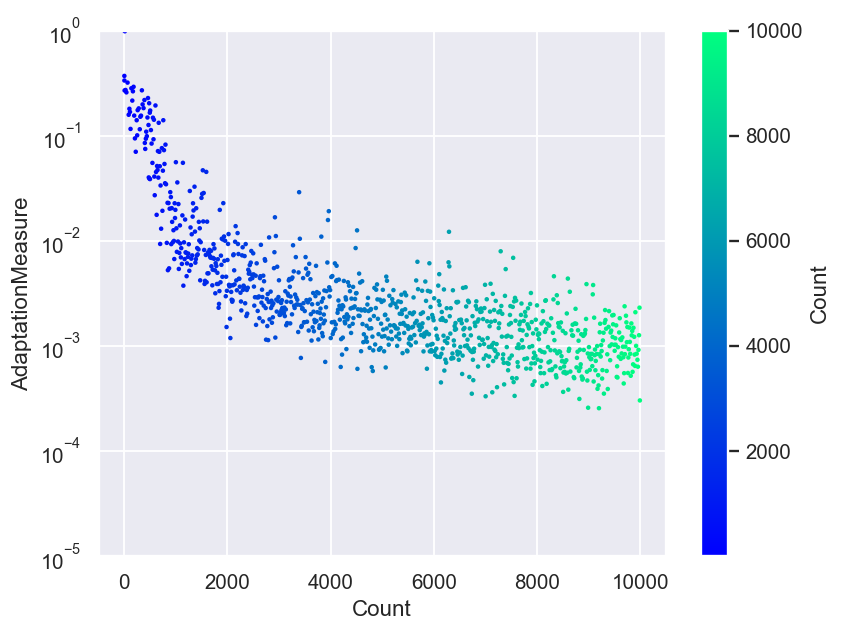

done in 0.315397 seconds.


In [12]:
chain.plot.scatter.scatter.kws.cmap = "winter"
chain.plot.scatter(ycolumns="AdaptationMeasure",ccolumns=[])
chain.plot.scatter.currentFig.axes.set_ylim([1.e-5,1])
chain.plot.scatter.currentFig.axes.set_yscale("log")

**The above graph looks quite reassuring**, since it clearly indicates that **the amount of adaptation of the proposal distribution decays toward zero very fast, like a power-law**. The initial sharp drop in the `AdaptationMeasure` represent the simulation episode during which the proposal distribution of the MCM sampler adjusts its shape to the shape of the target likelihood function.  

## Step 6: Visualize the sampled parameters  

We will now read the resulting sample from the output `*_sample.txt` file.  

In [13]:
pmpd.readSample() # read the final refined sample from the MCMC simulation
sample = pmpd.sampleList[0] 


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readSample()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the sample file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/censored*_sample.txt"


ParaDRAM - NOTE: processing sample file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\regression_censored_bivariate_lognormal_data_paradram\out\censored_process_1_sample.txt
ParaDRAM - NOTE: reading the file contents... done in 0.020196 seconds.
ParaDRAM - NOTE: ndim = 7, count = 2000
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM 

ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


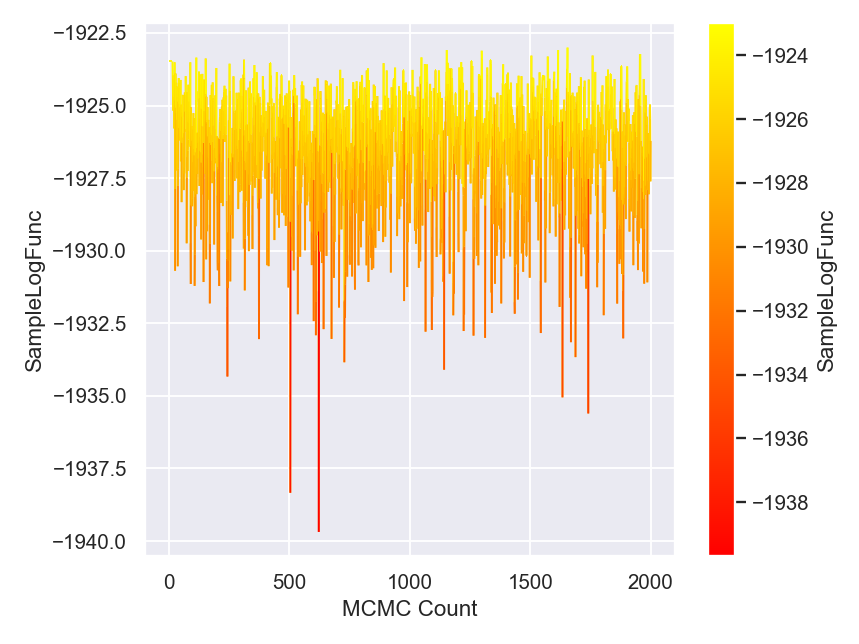

done in 0.323673 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_SampleLogFunc"
ParaDRAM - NOTE: done in 0.293022 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


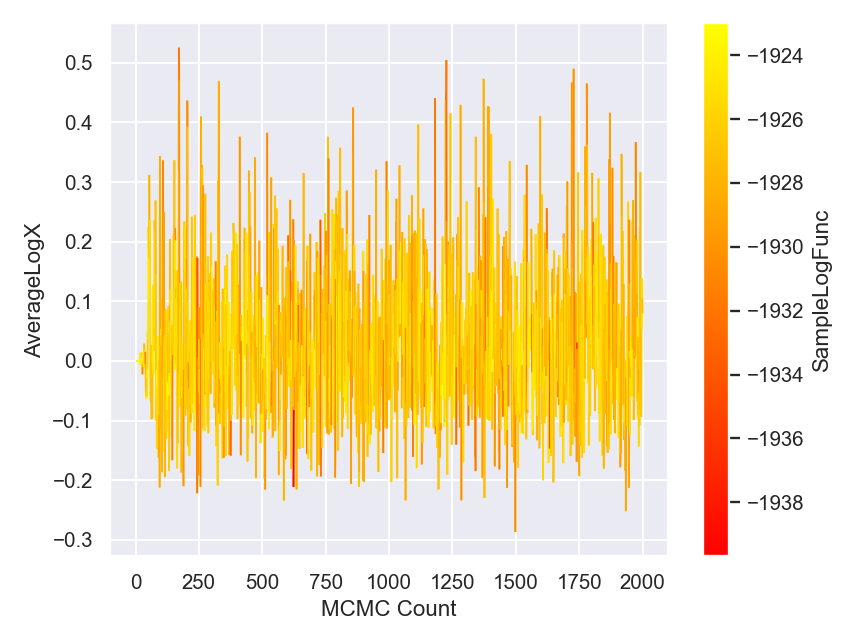

done in 0.276187 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_AverageLogX"
ParaDRAM - NOTE: done in 0.300825 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


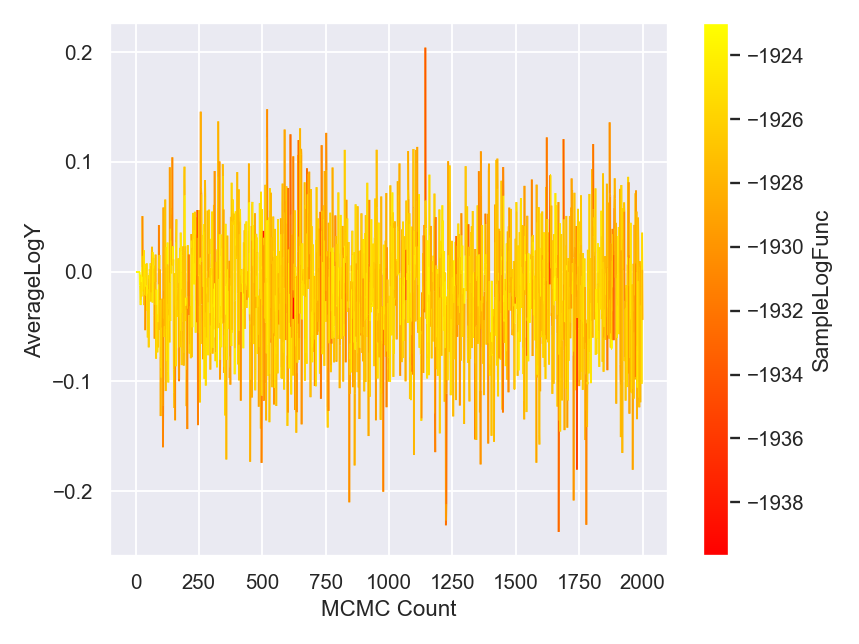

done in 0.262664 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_AverageLogY"
ParaDRAM - NOTE: done in 0.222685 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


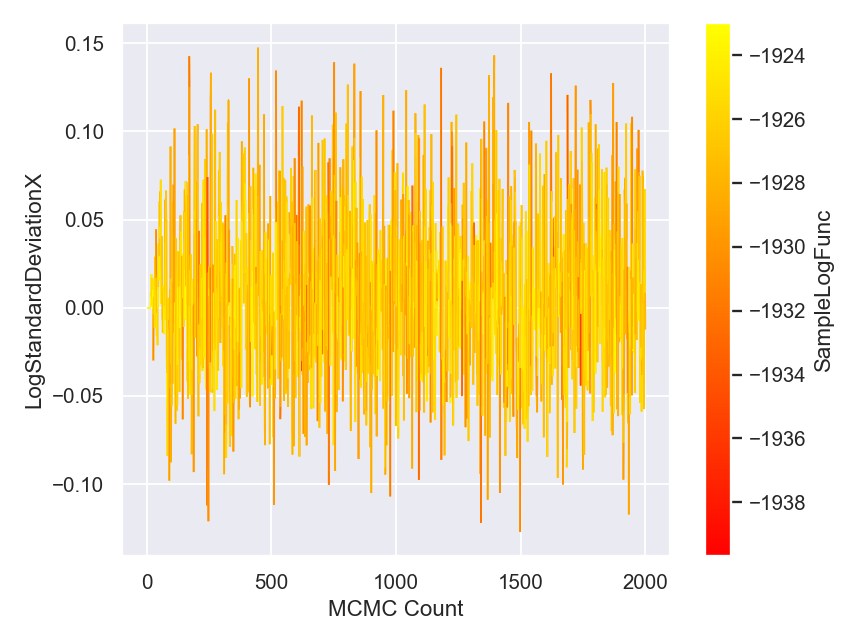

done in 0.263065 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_LogStandardDeviationX"
ParaDRAM - NOTE: done in 0.302383 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


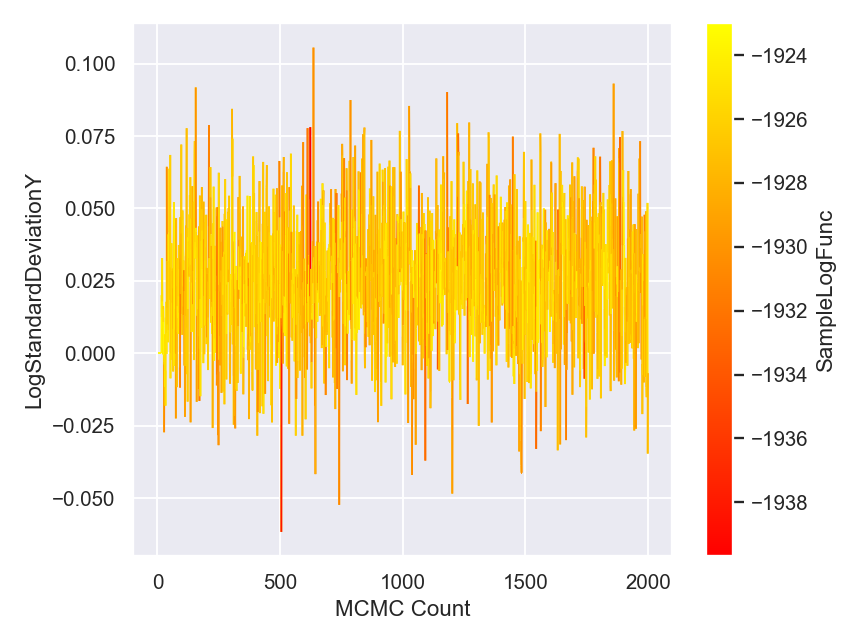

done in 0.29883 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_LogStandardDeviationY"
ParaDRAM - NOTE: done in 0.216174 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


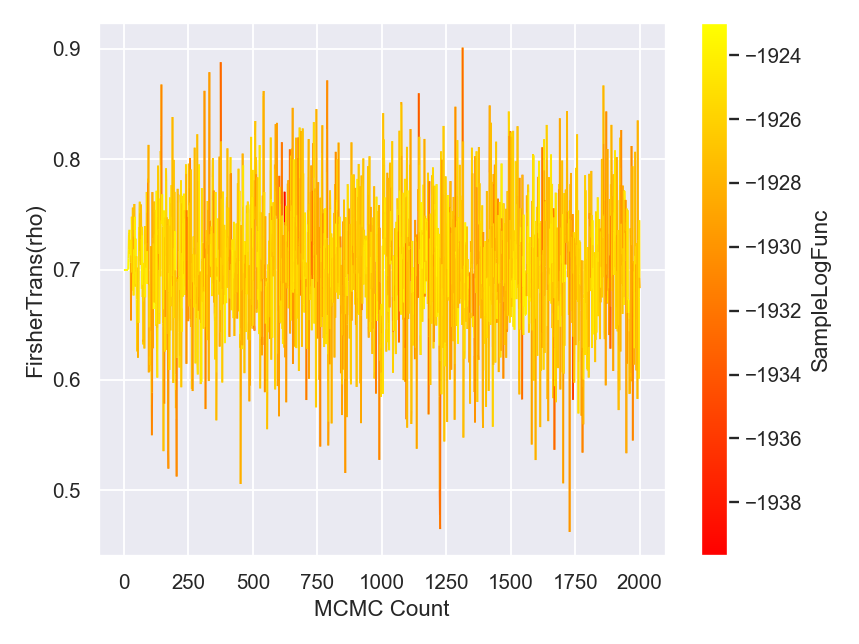

done in 0.300822 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_FirsherTrans(rho)"
ParaDRAM - NOTE: done in 0.43802 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


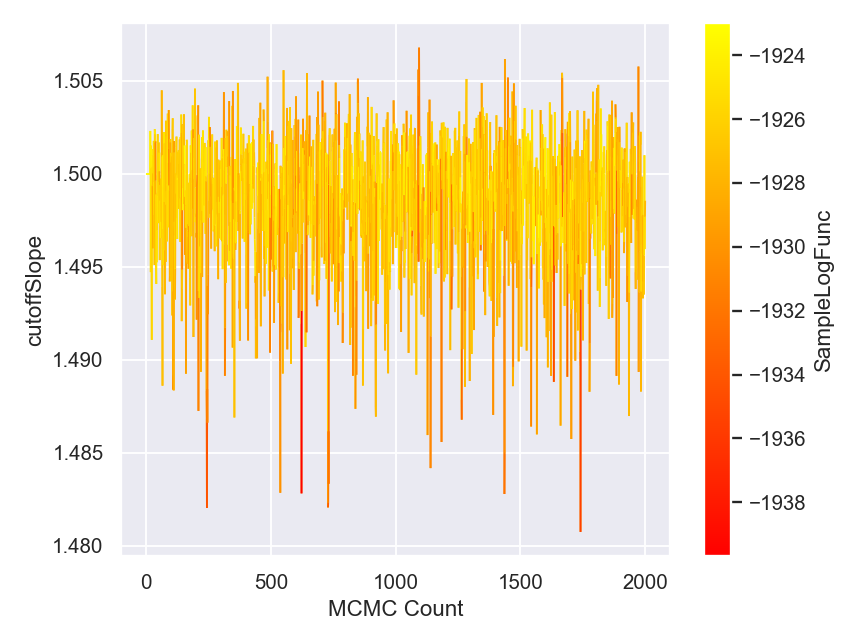

done in 0.31377 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_cutoffSlope"
ParaDRAM - NOTE: done in 0.311445 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


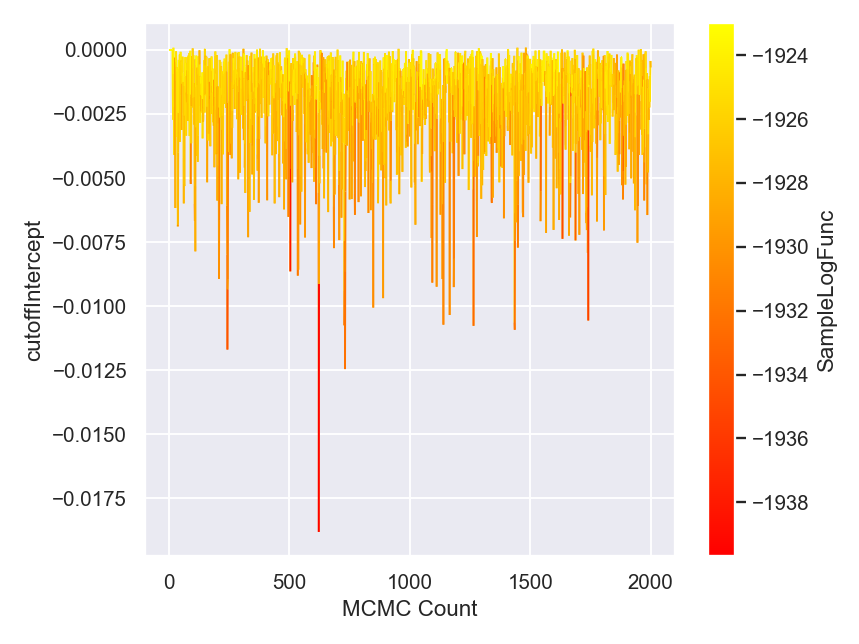

done in 0.364398 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_cutoffIntercept"
ParaDRAM - NOTE: done in 0.260912 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


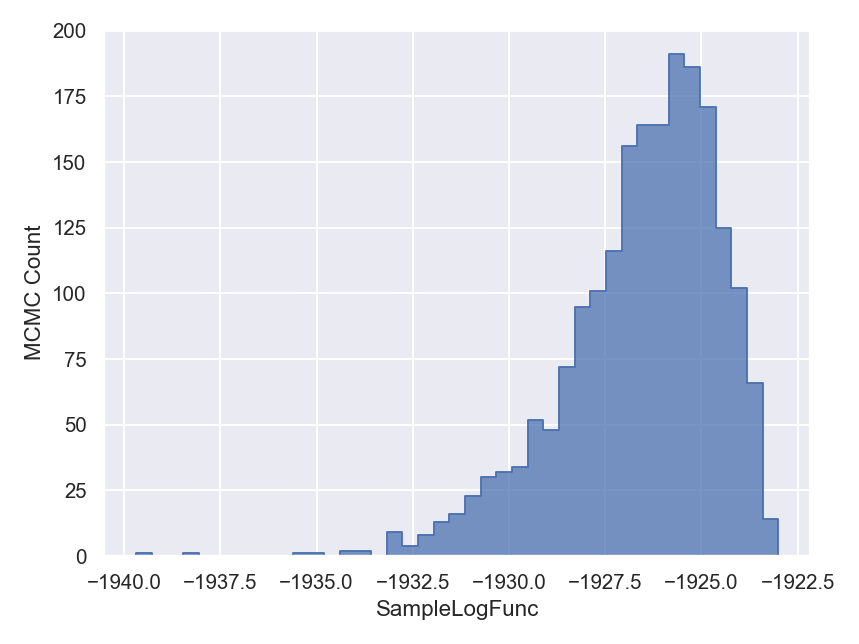

done in 0.230424 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_SampleLogFunc"
ParaDRAM - NOTE: done in 0.194229 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


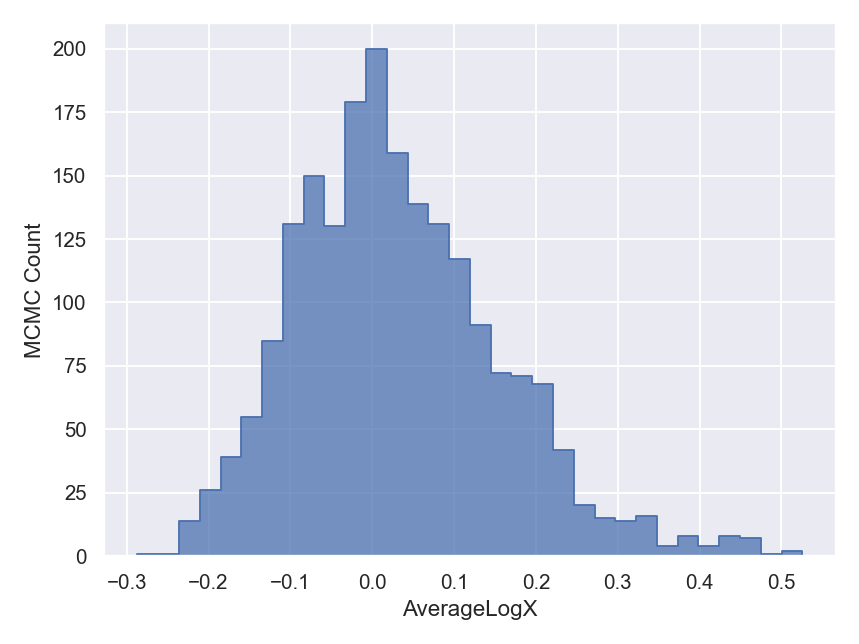

done in 0.263347 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_AverageLogX"
ParaDRAM - NOTE: done in 0.16182 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


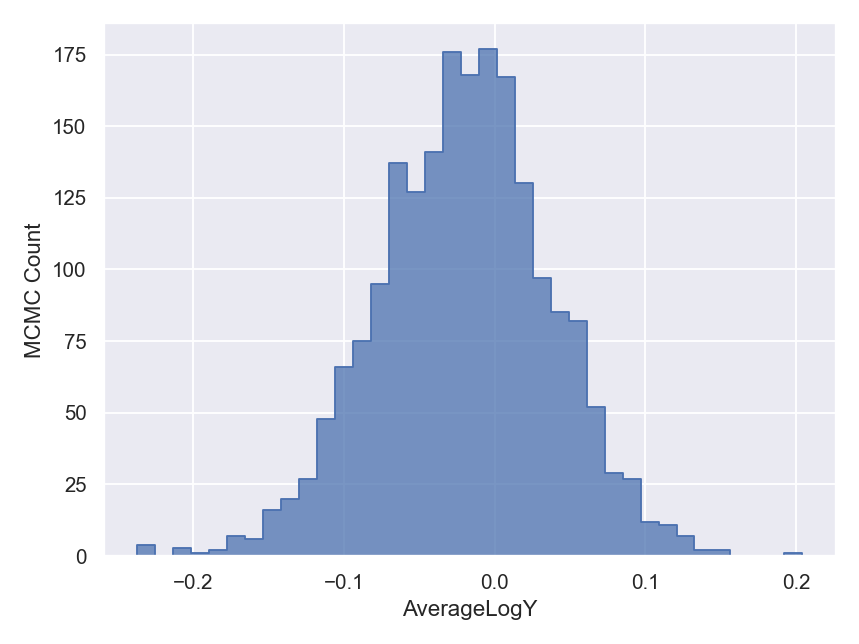

done in 0.202334 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_AverageLogY"
ParaDRAM - NOTE: done in 0.151657 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


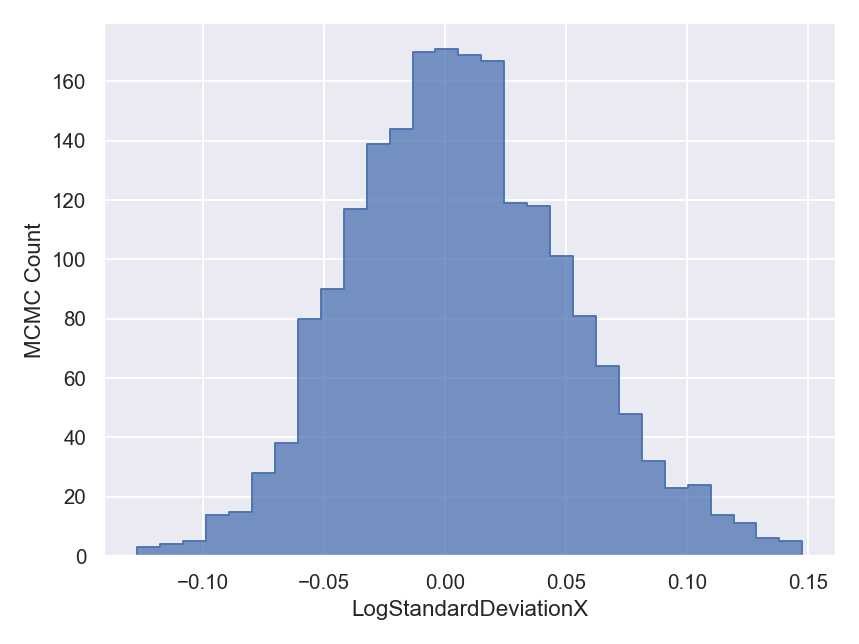

done in 0.283019 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_LogStandardDeviationX"
ParaDRAM - NOTE: done in 0.171935 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


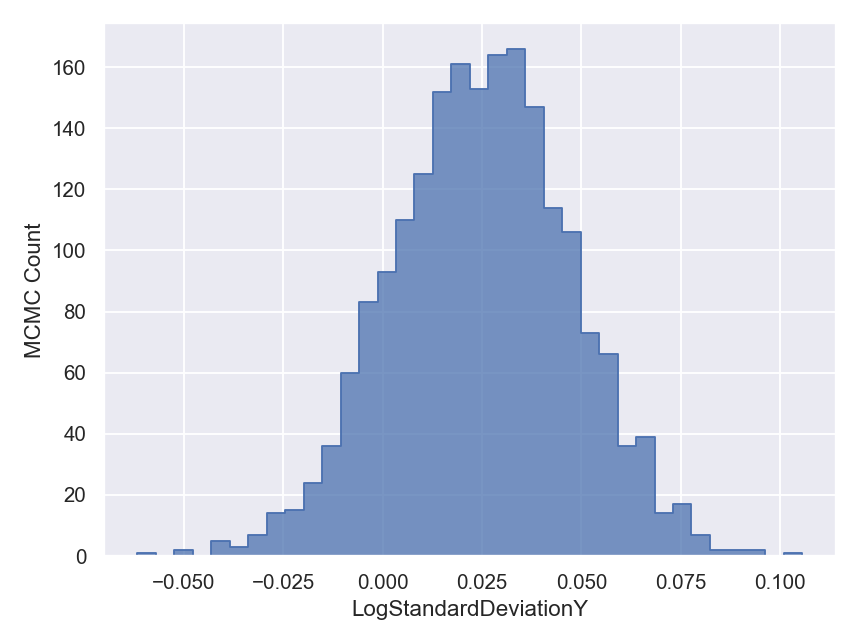

done in 0.204481 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_LogStandardDeviationY"
ParaDRAM - NOTE: done in 0.161712 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


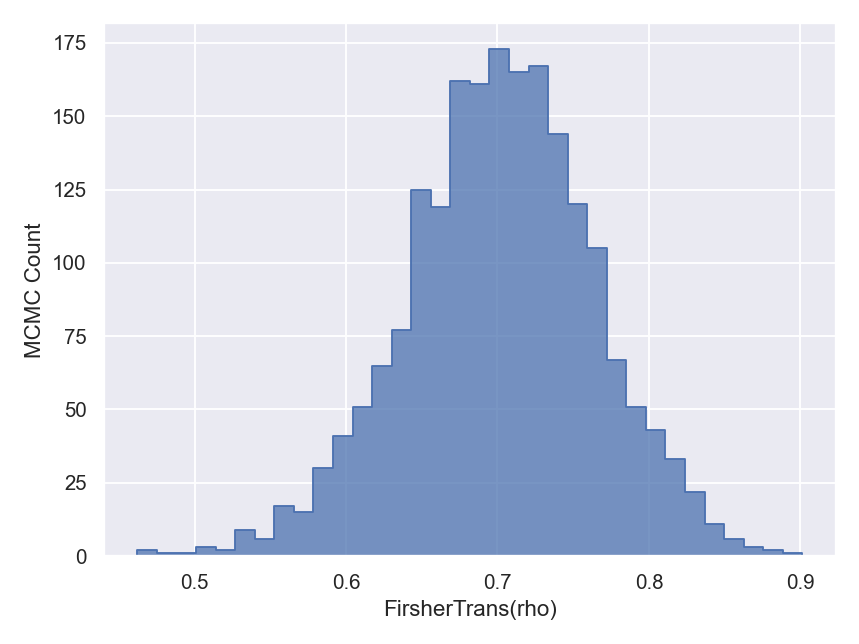

done in 0.228505 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_FirsherTrans(rho)"
ParaDRAM - NOTE: done in 0.162899 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


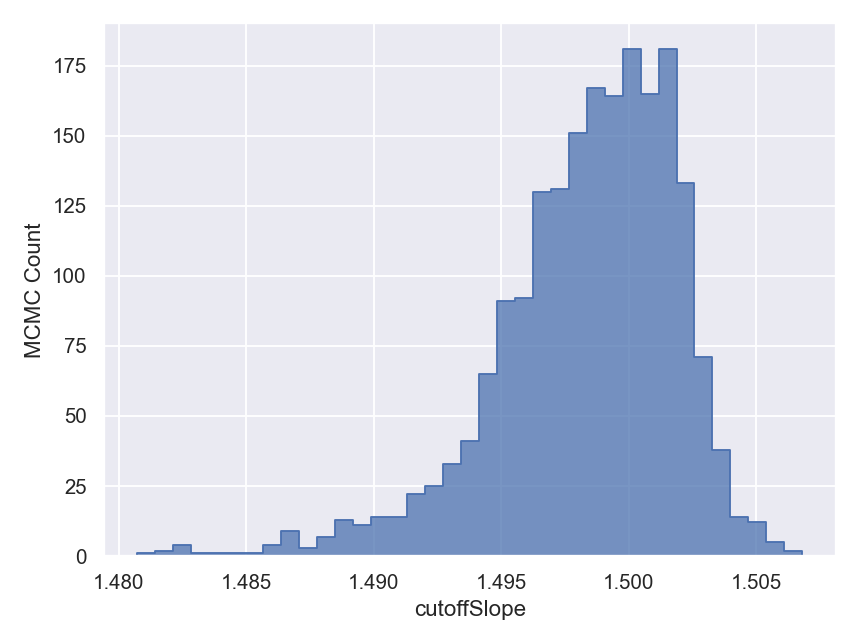

done in 0.222593 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_cutoffSlope"
ParaDRAM - NOTE: done in 0.15969 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


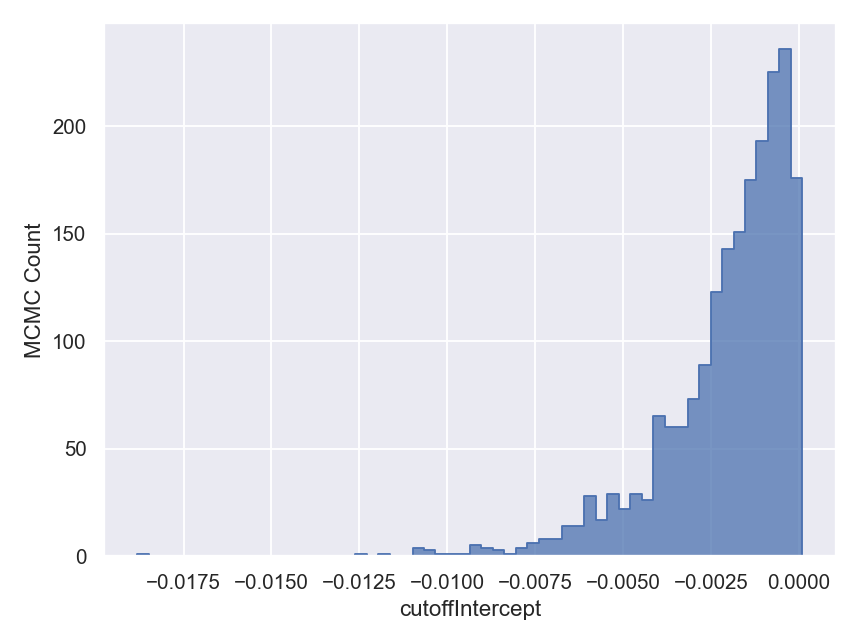

done in 0.253174 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_cutoffIntercept"
ParaDRAM - NOTE: done in 0.182244 seconds.


SampleLogFunc           -1926.551201
AverageLogX                 0.031936
AverageLogY                -0.020471
LogStandardDeviationX       0.006494
LogStandardDeviationY       0.024787
FirsherTrans(rho)           0.701652
cutoffSlope                 1.498383
cutoffIntercept            -0.002046
dtype: float64

In [14]:
# plot the sampled variables

for colname in pmpd.sampleList[0].df.columns:
    sample.plot.line.ycolumns = colname
    sample.plot.line()
    sample.plot.line.currentFig.axes.set_xlabel("MCMC Count")
    sample.plot.line.currentFig.axes.set_ylabel(colname)
    sample.plot.line.savefig( fname = "./out/traceplot_" + colname )

# plot the histograms of the sampled parameters

for colname in pmpd.sampleList[0].df.columns:
    sample.plot.histplot(xcolumns = colname)
    sample.plot.histplot.currentFig.axes.set_xlabel(colname)
    sample.plot.histplot.currentFig.axes.set_ylabel("MCMC Count")
    sample.plot.histplot.savefig( fname = "./out/histogram_" + colname )

# report the average parameters

pmpd.sampleList[0].df.mean()

To visualize the correlation of the parameters with each other, we can make a grid plot of the sample,  

ParaDRAM - NOTE: making the grid plot... 


<IPython.core.display.Javascript object>


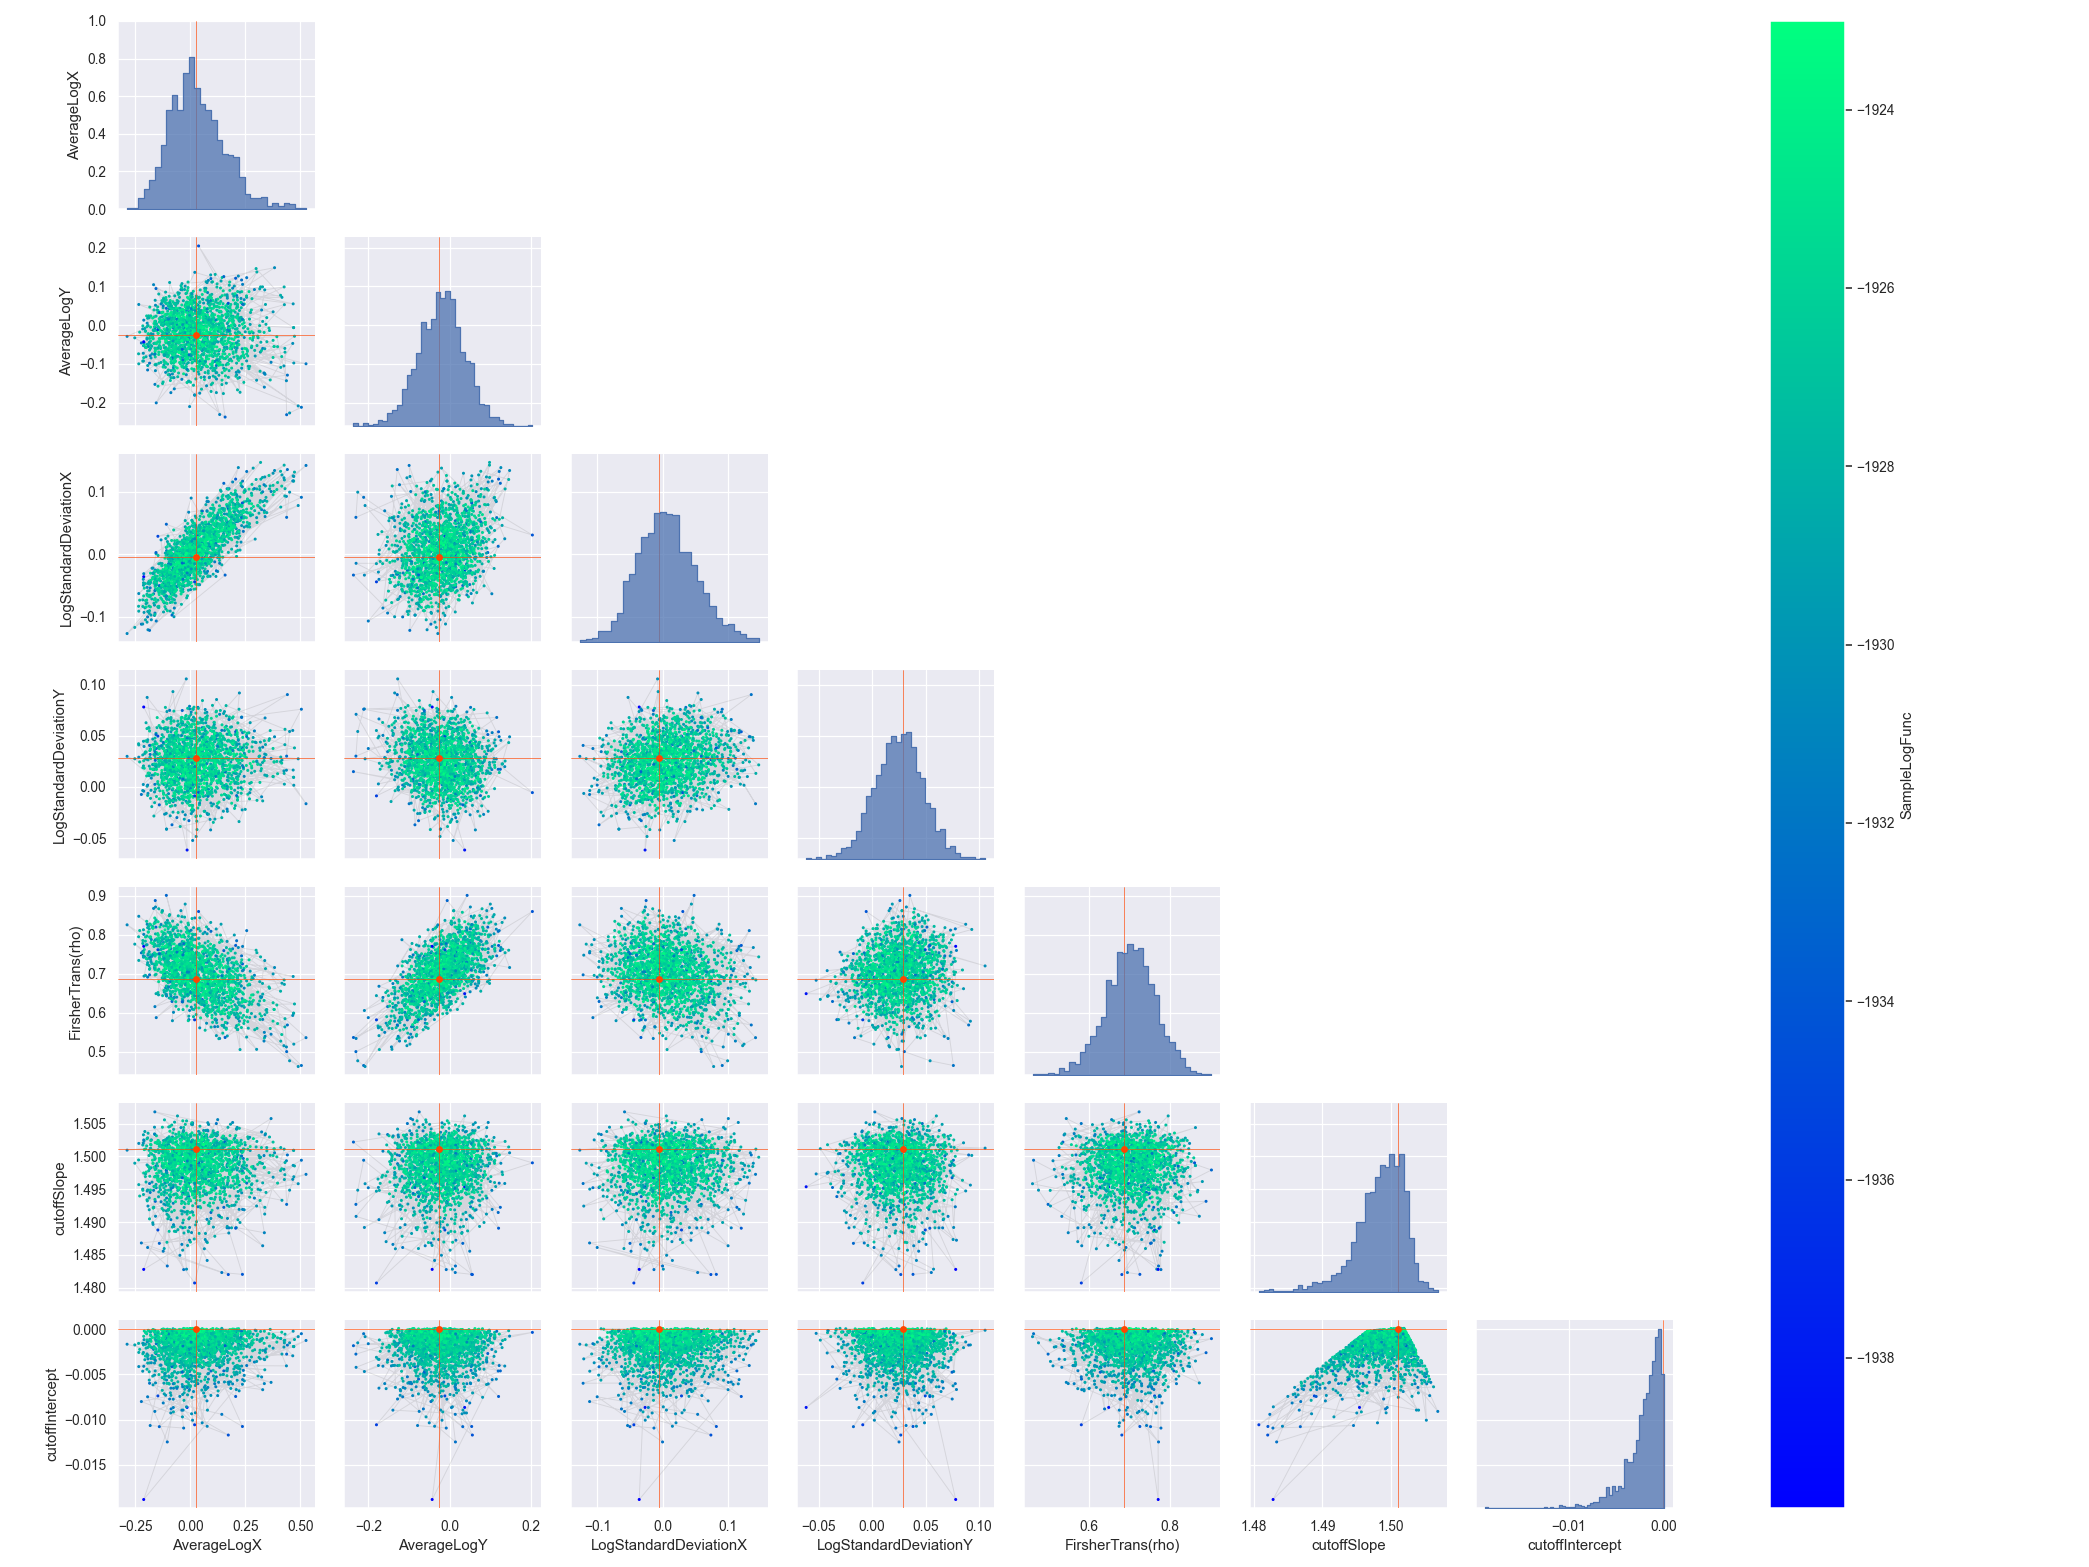

generating subplot #1: (0,0) out of 49... done in 0.071627 seconds.
generating subplot #2: (0,1) out of 49... done in 0.0 seconds.
generating subplot #3: (0,2) out of 49... done in 0.0 seconds.
generating subplot #4: (0,3) out of 49... done in 0.0 seconds.
generating subplot #5: (0,4) out of 49... done in 0.0 seconds.
generating subplot #6: (0,5) out of 49... done in 0.0 seconds.
generating subplot #7: (0,6) out of 49... done in 0.0 seconds.
generating subplot #8: (1,0) out of 49... done in 0.51702 seconds.
generating subplot #9: (1,1) out of 49... done in 0.071627 seconds.
generating subplot #10: (1,2) out of 49... done in 0.0 seconds.
generating subplot #11: (1,3) out of 49... done in 0.0 seconds.
generating subplot #12: (1,4) out of 49... done in 0.0 seconds.
generating subplot #13: (1,5) out of 49... done in 0.0 seconds.
generating subplot #14: (1,6) out of 49... done in 0.0 seconds.
generating subplot #15: (2,0) out of 49... done in 0.501404 seconds.
generating subplot #16: (2,1) 

In [15]:
sample.plot.grid.plotType.upper.enabled = False # disable upper triangle
sample.plot.grid.plotType.lower.value = "lineScatter" # let lower triangle be lineScatter plot
sample.plot.grid(columns = [1,2,3,4,5,6,7]) # make grid plot of all parameters
sample.plot.grid.addTarget() # add the maximum-likelihood set of parameters as the target value to all plot

### Ensuring independent and identical (i.i.d.) distribution of the final sampled states  

To ensure the iid distribution of the results, we can visualize the autocorrelation of the final refined sample,  

ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


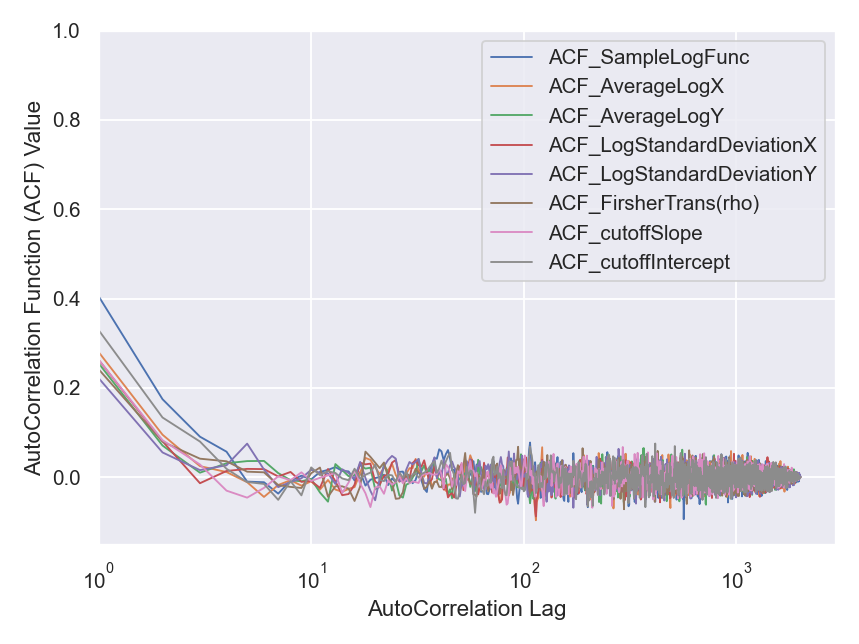

done in 0.363353 seconds.


In [16]:
sample.stats.autocorr.plot.line()

The above plots looks very good and reassuring. Compare it the autocorrelation of the Markov chain,  


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readMarkovchain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/censored*_chain.txt"


ParaDRAM - NOTE: processing chain file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\regression_censored_bivariate_lognormal_data_paradram\out\censored_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 1.742221 seconds.
ParaDRAM - NOTE: ndim = 7, count = 58738
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRA

<IPython.core.display.Javascript object>


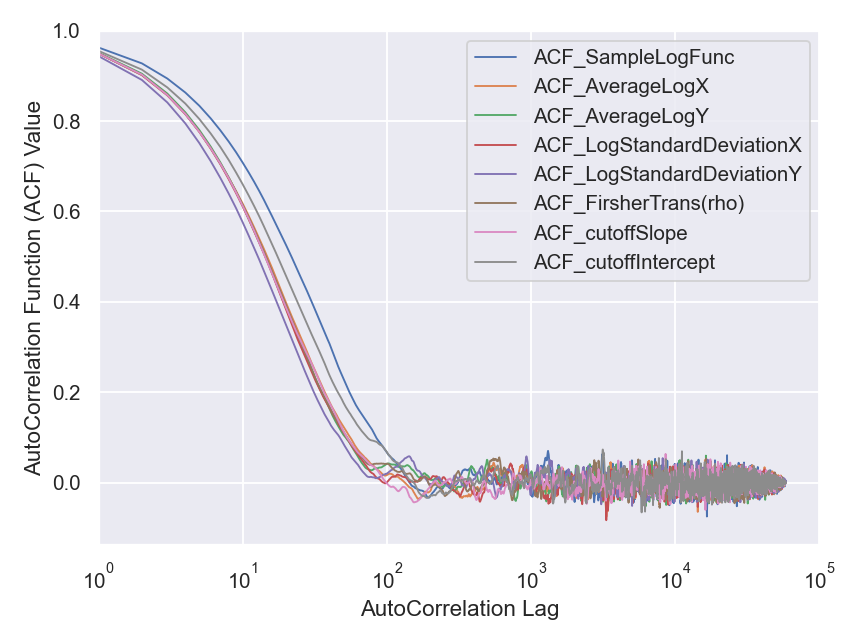

done in 0.770976 seconds.


In [17]:
mchain = pmpd.readMarkovChain(renabled=True)[0] # read the Markov chain
mchain.stats.autocorr.plot.line()

## Step 6: Display the inferred censorship line on the bivariate distribution of the observed data    


<IPython.core.display.Javascript object>


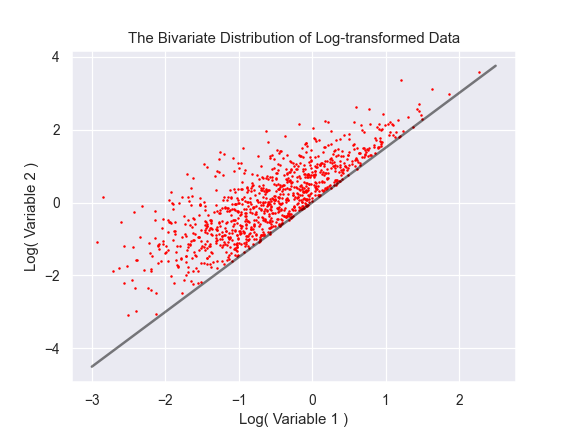

In [18]:
# plot the bivariate distribution of log(data)

fig = plt.figure()
ax = fig.gca()
ax.scatter(logX,logY,s=1,c="red")
plt.xlabel("Log( Variable 1 )")
plt.ylabel("Log( Variable 2 )")
plt.title('The Bivariate Distribution of Log-transformed Data')
plt.grid(True)

# add the best-fit censorship line

bestFitParam = chain.stats.maxLogFunc.state

xvalues = np.double([-3, 2.5])
ax.plot ( xvalues
        , bestFitParam[-2] * xvalues + bestFitParam[-1]
        , "black"
        , alpha=0.5
        , linewidth = 2
        )

plt.show()

>**There are many more functionalities and features of the ParaMonte library that were neither explored nor mentioned in this example Jupyter notebook. You can explore them by checking the existing components of each attribute of the ParaDRAM sampler class and by visiting the [ParaMonte library's documentation website](http://cdslab.org/paramonte/)**.